<div class="usecase-title"><padding-left: 15px><padding-bottom: 10px><padding-top: 10px>
    <padding-right: 15px>
    <background-color: #Black><p style="color:#14a38e;"><b>Pedestrains Accidents and Bus-stops</b></p></div>

<div class="usecase-authors"><b>Author: </b>Alison Collins</div>


<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data Preprocessing, Data Analysis, Modelling</div>
</div>

<div class="usecase-section-header">Scenario</div>

1. As a city planner, when considering bus stop locations and pedestrian safety, I want to identify if there is a relationship between bus stop locations and pedestrian numbers.

2. As a business owner, I want to visualise the potential of foot traffic against bus stops, to assist in decision making of new business locations.


<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Import data using API v2.1 GET request with /exports extension
- Import libraries, check for missing /null values in order to have a clean dataset
- Data visualisation by using matplotlib, dataframes, Geopandas
- Convert between Geodataframes and dataframes
- Use Geopandas to take subsamples of Geodataframes
- Allow user input
- Resample dataframes using date_time
- Mapping with folium incuding custom markers
- Oversampling, Undersampling and bootstrap approaches for imbalanced data classes
- Predictive modelling with Logistic Regression and Random Forest
- Understand results of confusion matrix, accuracy score and classification reports

<div class="usecase-section-header">Background</div>

Imagine the vibrant city of Melbourne grappling with the dual challenges of urban mobility and pedestrian flow. As the city evolves, so does the need for a transit system that not only efficiently moves people but also integrates seamlessly with the bustling pedestrian life. With the growing population, this city needs extensive mode of transportation network for the public; so isn't it important to understand the relationship between the bus-stops and pedestrains counts? </br>

To address this challenge, this study delves into the relationship between bus stops and pedestrian counts. The objective is to understand spatial and temporal patterns, identifying if there are areas where pedestrian activity peaks in conjunction with bus arrivals. This analysis becomes imperative to enhance urban planning. By optimizing this symbiotic relationship, the scenario aims to create a more seamless and efficient urban environment, improving both public transportation and the pedestrian experience in the heart of Melbourne.


<div class="usecase-section-header">Relevant Datasets</div>

[Bus Stops](https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/information/)

- This dataset shows the Melbourne City Bus Stop locations. For this investigation, the most important  columns are those that hold the geographical position of the bus stop. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Pedestrian Counting System (counts per hour)](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/)
- The city of Melbourne has been fitted with sensors across it's area. The sensors are fixed and count the motion throught the zone in multidirections <a href="#fn-1">[1]</a> to monotor pedestrian movement. This data is in this set is collated hourly and includes an interger measurement value of motion in each direction as well as a toal. The geographica location of each sensot is included and can be used to join this dataset with the bus stop dataset. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

### REQUIRED MODULES

In [11]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")

import requests
import pandas as pd
pd.set_option('display.max_columns', None)
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import scikitplot as skplt
import plotly.express as px

from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

### IMPORT DATASETS

In [12]:
#Function to collect data using API v 2.1
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key #use if use datasets API_key permissions
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey  #use if datasets require API_key permissions
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [33]:
# IMPORT BUS STOPS DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'bus-stops'
# Save dataset to df varaible
bus_data = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(bus_data)} records.')
# View df
bus_data.head(3)

The dataset contains 309 records.


,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,asset_subt,model_desc,mcc_id,roadseg_id,descriptio,model_no
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,NaN,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,NaN,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,NaN,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16


In [34]:
# IMPORT PEDESTRIAN COUNTING DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'pedestrian-counting-system-monthly-counts-per-hour'
# Save dataset to df varaible
ped_data = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(ped_data)} records.')
# View df
ped_data.head(3)

The dataset contains 549976 records.


,sensor_name,timestamp,locationid,direction_1,direction_2,total_of_directions,location
0,SprFli_T,2023-04-24T21:00:00+00:00,75,36,17,53,"-37.81515276, 144.97467661"
1,SprFli_T,2023-04-25T00:00:00+00:00,75,28,50,78,"-37.81515276, 144.97467661"
2,SprFli_T,2023-04-25T01:00:00+00:00,75,63,63,126,"-37.81515276, 144.97467661"


In [35]:
# URL to the GeoJSON file
url = 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Road_Safety/VICTORIAN_ROAD_CRASH_DATA.geojson'

# Set the User-Agent to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# Make the HTTP request
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Load GeoJSON data into a pandas DataFrame
    data = response.json()
    features = data['features']
    properties_data = [feature['properties'] for feature in features]
    crash_data = pd.DataFrame(properties_data)
    print(f'The dataset contains {len(df)} records.')
else:
    print(f'Failed to retrieve data: {response.status_code}')

# View df
crash_data.head(3)

The dataset contains 167043 records.


,ACCIDENT_NO,ACCIDENT_DATE,ACCIDENT_TIME,ACCIDENT_TYPE,DAY_OF_WEEK,DCA_CODE,LIGHT_CONDITION,POLICE_ATTEND,ROAD_GEOMETRY,SEVERITY,SPEED_ZONE,RUN_OFFROAD,NODE_ID,NODE_TYPE,LGA_NAME,LATITUDE,LONGITUDE,VICGRID_X,VICGRID_Y,TOTAL_PERSONS,INJ_OR_FATAL,FATALITY,SERIOUSINJURY,OTHERINJURY,NONINJURED,MALES,FEMALES,BICYCLIST,PASSENGER,DRIVER,PEDESTRIAN,PILLION,MOTORCYCLIST,UNKNOWN,PED_CYCLIST_5_12,PED_CYCLIST_13_18,OLD_PED_65_AND_OVER,OLD_DRIVER_75_AND_OVER,YOUNG_DRIVER_18_25,NO_OF_VEHICLES,HEAVYVEHICLE,PASSENGERVEHICLE,MOTORCYCLE,PT_VEHICLE,DEG_URBAN_NAME,SRNS,RMA,DIVIDED,STAT_DIV_NAME
0,T20120000009,20120101,022500,Collision with a fixed object,Sunday,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,Dark No street lights,Yes,Not at intersection,Other injury accident,100 km/hr,Yes,249102,Non-Intersection,BAW BAW,-38.234957,145.726709,2563628.962,2362700.434,2,2,0,0,2,0,2,0,0,1,1,0,0,0,0,0,0,0,0,1,1.0,0.0,1.0,0.0,0.0,RURAL_VICTORIA,C,Arterial Other,Undivided,Country
1,T20120000012,20120101,020000,Collision with vehicle,Sunday,CROSS TRAFFIC(INTERSECTIONS ONLY),Dark Street lights on,Yes,Cross intersection,Serious injury accident,80 km/hr,No,41780,Non-Intersection,MONASH,-37.903541,145.161404,2514194.683,2399718.586,3,1,0,1,0,2,2,0,0,1,2,0,0,0,0,0,0,0,0,0,2.0,0.0,2.0,0.0,0.0,MELB_URBAN,None,Arterial Highway,Divided,Metro
2,T20120000013,20120101,033500,Collision with vehicle,Sunday,VEHICLE COLLIDES WITH VEHICLE PARKED ON LEFT O...,Dark Street lights on,Yes,T intersection,Serious injury accident,60 km/hr,No,69811,Intersection,KINGSTON,-37.935940,145.098848,2508689.410,2396130.003,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2.0,0.0,2.0,0.0,0.0,MELB_URBAN,None,Arterial Other,Undivided,Metro


### DATASET PREPROCESSING

#### Bus Stop Data

Check columns and delete those not needed for analysis. Check for null vlaues and delete any rows with missing values. Check data types in columns.

In [36]:
# Check the names of the columns
column_names = bus_data.columns.tolist()
print("\033[1mColumn names:\033[0m")
print(column_names)

Column names:
['geo_point_2d', 'geo_shape', 'prop_id', 'addresspt1', 'addressp_1', 'asset_clas', 'asset_type', 'objectid', 'str_id', 'addresspt', 'asset_subt', 'model_desc', 'mcc_id', 'roadseg_id', 'descriptio', 'model_no']


In [37]:
# Drop the unnesccessary columns, save back to bus variable
bus = bus_data[["geo_shape","addresspt1","asset_type"]]

# Extract latitude and longitude from geo_shape
bus['coordinates'] = bus['geo_shape'].apply(lambda x: eval(x)['coordinates'])
bus[['longitude', 'latitude']] = pd.DataFrame(bus['coordinates'].tolist(), index=bus.index)
bus.head(2)

,geo_shape,addresspt1,asset_type,coordinates,longitude,latitude
0,"{""coordinates"": [144.93239283833262, -37.80384...",76.819824,Sign - Public Transport,"[144.93239283833262, -37.80384165792465]",144.932393,-37.803842
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487


In [38]:
# Check for null values
print("\033[1mNaN Value in Bus-stop Data:\033[0m")
print(bus.isna().sum())

NaN Value in Bus-stop Data:
geo_shape      0
addresspt1     0
asset_type     0
coordinates    0
longitude      0
latitude       0
dtype: int64


In [39]:
# Check data types
print("\033[1m\nData Types in Bus-stop Data:\033[0m")
print(bus.dtypes)


Data Types in Bus-stop Data:
geo_shape       object
addresspt1     float64
asset_type      object
coordinates     object
longitude      float64
latitude       float64
dtype: object


#### Pedestrian Data

Check columns and delete those not needed for analysis. Check for null vlaues and delete any rows with missing values. Check data types in columns.

In [40]:
# Check the names of the columns
column_names = ped_data.columns.tolist()
print("\033[1mColumn names:\033[0m")
print(column_names)

Column names:
['sensor_name', 'timestamp', 'locationid', 'direction_1', 'direction_2', 'total_of_directions', 'location']


In [63]:
# Drop the sensor_name column, save back to ped variable
ped = ped_data.drop(['sensor_name'], axis=1)

# Split "Location" column into "Latitude" and "Longitude" for pedestrian counts
ped[['latitude', 'longitude']] = ped['location'].str.split(', ', expand=True).astype(float)

ped.head(2)

,timestamp,locationid,direction_1,direction_2,total_of_directions,location,latitude,longitude
0,2023-04-24T21:00:00+00:00,75,36,17,53,"-37.81515276, 144.97467661",-37.815153,144.974677
1,2023-04-25T00:00:00+00:00,75,28,50,78,"-37.81515276, 144.97467661",-37.815153,144.974677


In [64]:
# Check for Null Values in Pedestrian Count Data
print("\033[1m\nNaN Values in Pedestrian Count Data:\033[0m")
print(ped.isna().sum())


NaN Values in Pedestrian Count Data:
timestamp              0
locationid             0
direction_1            0
direction_2            0
total_of_directions    0
location               0
latitude               0
longitude              0
dtype: int64


In [66]:
# Check data types
print("\033[1m\nData Types in Bus-stop Data:\033[0m")
print(ped.dtypes)


Data Types in Bus-stop Data:
timestamp               object
locationid               int64
direction_1              int64
direction_2              int64
total_of_directions      int64
location                object
latitude               float64
longitude              float64
dtype: object


#### Crash Data

Check columns and delete those not needed for analysis. Select only the data where pedestrians were involved in accidents. Check for null vlaues and delete any rows with missing values. Check data types in columns.

In [43]:
# CHeck the names of the columns
column_names = crash_data.columns.tolist()
print(column_names)

['ACCIDENT_NO', 'ACCIDENT_DATE', 'ACCIDENT_TIME', 'ACCIDENT_TYPE', 'DAY_OF_WEEK', 'DCA_CODE', 'LIGHT_CONDITION', 'POLICE_ATTEND', 'ROAD_GEOMETRY', 'SEVERITY', 'SPEED_ZONE', 'RUN_OFFROAD', 'NODE_ID', 'NODE_TYPE', 'LGA_NAME', 'LATITUDE', 'LONGITUDE', 'VICGRID_X', 'VICGRID_Y', 'TOTAL_PERSONS', 'INJ_OR_FATAL', 'FATALITY', 'SERIOUSINJURY', 'OTHERINJURY', 'NONINJURED', 'MALES', 'FEMALES', 'BICYCLIST', 'PASSENGER', 'DRIVER', 'PEDESTRIAN', 'PILLION', 'MOTORCYCLIST', 'UNKNOWN', 'PED_CYCLIST_5_12', 'PED_CYCLIST_13_18', 'OLD_PED_65_AND_OVER', 'OLD_DRIVER_75_AND_OVER', 'YOUNG_DRIVER_18_25', 'NO_OF_VEHICLES', 'HEAVYVEHICLE', 'PASSENGERVEHICLE', 'MOTORCYCLE', 'PT_VEHICLE', 'DEG_URBAN_NAME', 'SRNS', 'RMA', 'DIVIDED', 'STAT_DIV_NAME']


In [51]:
# Select only the rows where pedestrians are involved
crash = crash_data.drop(crash_data[crash_data['PEDESTRIAN'] == 0].index)

# Drop the unnesccessary columns, save back to bus variable
crash = crash[["ACCIDENT_DATE","ACCIDENT_TIME","PEDESTRIAN","SEVERITY","LATITUDE","LONGITUDE"]]

# Rename columns to lowercase
crash.columns = [col.lower() for col in crash.columns]

crash.head(2)

,accident_date,accident_time,pedestrian,severity,latitude,longitude
6,20120101,005500,1,Other injury accident,-37.841733,144.953222
9,20120101,162500,1,Other injury accident,-38.367171,144.877550


In [55]:
# Check for null values in crash data
print("\033[1m\nNaN Values in Crash Data:\033[0m")
print(crash.isna().sum())


NaN Values in Crash Data:
accident_date    0
accident_time    0
pedestrian       0
severity         0
latitude         0
longitude        0
dtype: int64


In [57]:
# Convert the date and time columns to strings
crash['accident_date'] = crash['accident_date'].astype(str)
crash['accident_time'] = crash['accident_time'].astype(str)

# Combine accident date and time to make a timestamp column
crash['timestamp'] = pd.to_datetime(crash['accident_date'] + ' ' + crash['accident_time'], format='mixed')

crash.head(2)

,accident_date,accident_time,pedestrian,severity,latitude,longitude,timestamp
6,20120101,005500,1,Other injury accident,-37.841733,144.953222,2012-01-01 00:55:00
9,20120101,162500,1,Other injury accident,-38.367171,144.877550,2012-01-01 16:25:00


In [58]:
unique_values = crash['severity'].unique()
print(unique_values)

['Other injury accident' 'Serious injury accident' 'Fatal accident']


In [59]:
unique_values = crash['pedestrian'].unique()
print(unique_values)

[1 2 3 5 4 6 7 9]


In [67]:
# Check data types
print("\033[1m\nData Types in Crash Data:\033[0m")
print(crash.dtypes)


Data Types in Crash Data:
accident_date            object
accident_time            object
pedestrian                int64
severity                 object
latitude                float64
longitude               float64
timestamp        datetime64[ns]
dtype: object


### EXPLORATORY DATA ANALYSIS

#### Pedestrian Data

Exploratory Data Analysis will be used to gain insights into the datasets. First an investigation of the total numbers of pedestrians.

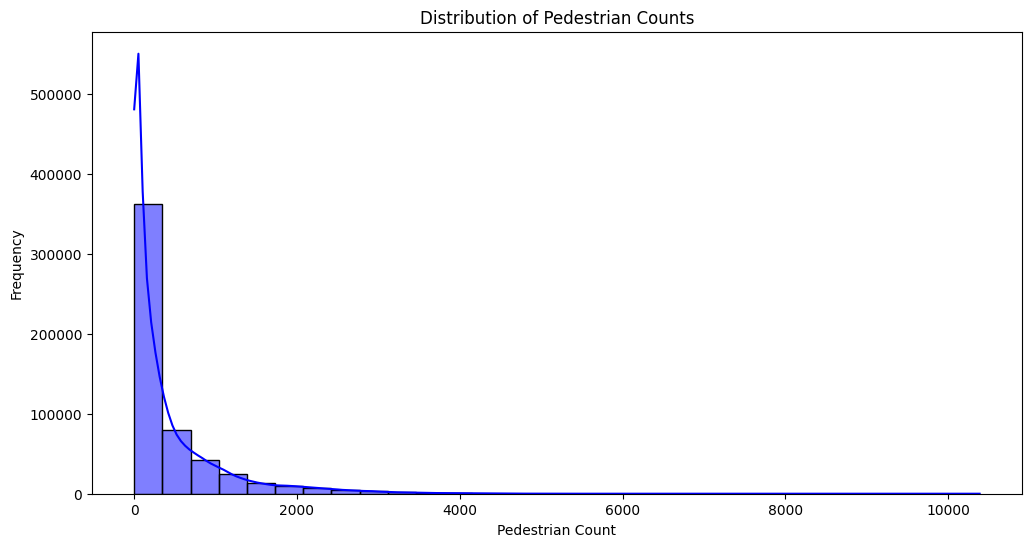

In [92]:
# Plot the distribution of pedestrian counts
plt.figure(figsize=(12, 6))
sns.histplot(ped['total_of_directions'], bins=30, kde=True, color='blue')
plt.title('Distribution of Pedestrian Counts')
plt.xlabel('Pedestrian Count')
plt.ylabel('Frequency')
plt.show()

The distribution of pedestrian counts shows how often each number of pedestrians is seen. This shows that very often less than 200 pedestrians were seen, with few days recording more than 2000 pedestrians. The highest pedestrian count is over 10,000.

Next an exploration of the temporal patterns in total numbers of pedestrians will be carried out.

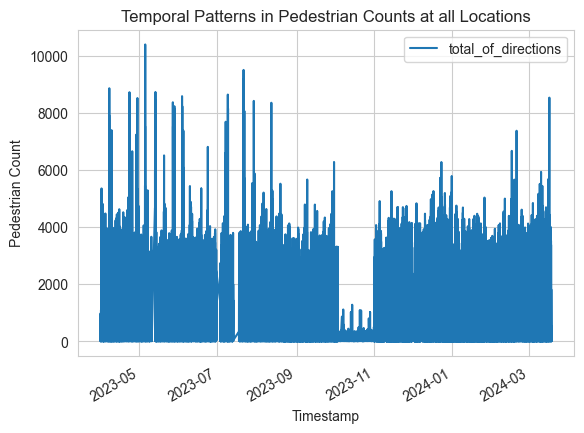

In [ ]:
# Convert the timestamp column to datetime type data
ped['timestamp'] = pd.to_datetime(ped['timestamp'], utc=True)

# Plot temporal patterns in pedestrian counts at alll locations
ped.plot.line(x='timestamp', y='total_of_directions')
plt.title('Temporal Patterns in Pedestrian Counts at all Locations')
plt.xlabel('Timestamp')
plt.ylabel('Pedestrian Count')
plt.show()


The temporal pattern in pedestrian data illustrates pedestrian numbers per hour in the Melbourne area. There are obvious gaps in this data. From the checks for null values above, there are no missing values in this dataset. This means there must be dates missing where data has not been recorded. 

#### Crash Data

Count the number of accidents occurring on each day and display in a temporal graph.

In [96]:
# Group the data by the date and count the rows for each date, make new dataframe
date_counts = crash.groupby(crash['timestamp'].dt.date).size().reset_index(name='count')

# Rename the columns for clarity
date_counts.columns = ['date', 'count']

# Display the new dataframe
date_counts.head(2)

,date,count
0,2012-01-01,2
1,2012-01-02,1


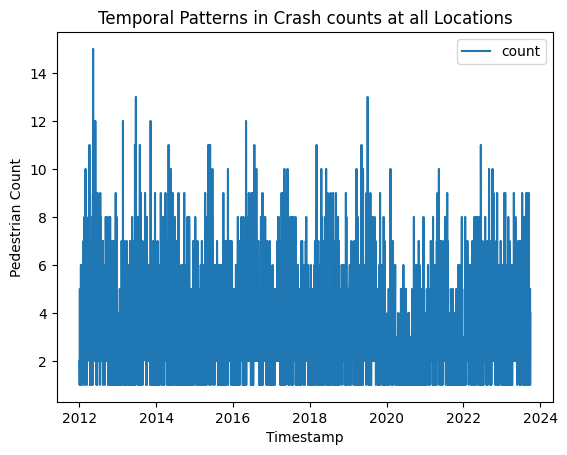

In [98]:
# Plot temporal patterns in pedestrian counts at alll locations
date_counts.plot.line(x='date', y='count')
plt.title('Temporal Patterns in Crash counts at all Locations')
plt.xlabel('Timestamp')
plt.ylabel('Pedestrian Count')
plt.show()

Temporal patterns in crash data shows that the dataset is over 12 years. The maximum number of crashes is 15, with many days at 0 recorded crashes. 

A view of both the of locations of pedestrian counting, accidents and bus stop locations at the same time allows investgation of if there is overlap between these datasets.

In [85]:
# Reduce the ped dataframe

# Create a new dataFrame from the unique values in locationid column
ped_loc = ped.drop_duplicates(subset=['locationid'], keep='first')


In [86]:
# Create GeoDataFrames
gdf_bus = gpd.GeoDataFrame(bus, geometry=gpd.points_from_xy(bus['latitude'], bus['longitude']))

gdf_ped_loc = gpd.GeoDataFrame(ped_loc, geometry=gpd.points_from_xy(ped_loc['latitude'], ped_loc['longitude']))

gdf_crash = gpd.GeoDataFrame(crash, geometry=gpd.points_from_xy(crash['latitude'], crash['longitude']))

In [83]:
# Reduce bus stop df to max and min of pedestrian count df
# Find total boundaries of lane df
minx, miny, maxx, maxy = gdf_ped_loc.geometry.total_bounds
# Filter ped by longitude max and min
df_filtered = gdf_bus[gdf_bus['latitude'].between(minx-0.0001, maxx+0.0001)]
# Filter ped by latitude max and min
gdf_bus_small = df_filtered[df_filtered['longitude'].between(miny-0.0001, maxy+0.0001)]

In [84]:
# Reduce crash stop df to max and min of pedestrian count df
# Filter crash by longitude max and min
df_filtered = gdf_crash[gdf_crash['latitude'].between(minx-0.0001, maxx+0.0001)]
# Filter crash by latitude max and min
gdf_crash_small = df_filtered[df_filtered['longitude'].between(miny-0.0001, maxy+0.0001)]

In [91]:
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.815, 144.96],zoom_start = 14)

# Add a circle marker for each accident location  
for i in range(0,len(gdf_crash_small)):
    folium.Circle(
        location=[gdf_crash_small.iloc[i]['latitude'], gdf_crash_small.iloc[i]['longitude']],
        radius=50,
        color='red',
        fill_color='red'
   ).add_to(m)
    
# Add a circle marker for each bus stop location
for i in range(0,len(gdf_bus_small)):
    folium.Circle(
        location=[gdf_bus_small.iloc[i]['latitude'], gdf_bus_small.iloc[i]['longitude']],
        radius=50,
        color='black',
        fill_color='black'
   ).add_to(m)

# Add a circle marker for eahc pedestrian count location  
for i in range(0,len(gdf_ped_loc)):
    folium.Circle(
        location=[gdf_ped_loc.iloc[i]['latitude'], gdf_ped_loc.iloc[i]['longitude']],
        radius=50,
        color='blue',
        fill_color='blue'
   ).add_to(m)

# Title for map
m.get_root().html.add_child(folium.Element("<h3 align='center'>Locations of Accidents, Pedestrian Counts and Bus Stop Location</h3>"))

m

This map shows the locations of bus stops and pedestrian count data. It can be seen that there are some locations where the pedestrian counting takes place near the bus stop locations. It would be useful to view the numbers of pedestrians where there are and where there are not bus stop locations. This can be achieved by adding a column that identifies locations as having a bus stop (1) or no bus stop present (0). The folium map is zoomable to allow better investigation of the exact overlapping locations where both bus stops and pedestrain counters are.

In [ ]:
# select only the locations where there is overlap in the data, i.e. both pedestrian count and bus stop
import warnings
warnings.filterwarnings("ignore")
# Find rows from where the bus stops and pedestrian counts intersect
# Use sjoin_nearest method to do an inner join on bus stop small and ped
# Set the max_distance to allow for small discrepencies in locations
bus_ped_overlap_gdf = gdf_bus_small.sjoin_nearest(gdf_ped, max_distance=0.0003)
bus_ped_overlap_gdf = bus_ped_overlap_gdf[["Latitude_left","Longitude_left","geometry","timestamp","direction_1","direction_2","total_of_directions"]]
# Print length of dataframe to find number of laneways impacted by surface water flow
print(len(bus_ped_overlap_gdf))
bus_ped_overlap_gdf.head(2)

58274


,Latitude_left,Longitude_left,geometry,timestamp,direction_1,direction_2,total_of_directions
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-12-29 17:00:00+00:00,0,1,1
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-12-29 18:00:00+00:00,2,1,3


In [ ]:
# add columne with value 1 for has bus stops to joined df
bus_ped = bus_ped_overlap_gdf.assign(bus_stop=1) 
# Rename columns to same as ped to allow for merge
bus_ped = bus_ped.rename(columns={"Latitude_left": "Latitude","Longitude_left":"Longitude"})
bus_ped.head(3)

# Print column names and data types
print("\033[1m\nData Types in Overlapping Bus Stop and Pedestrian Data:\033[0m")
print(bus_ped.dtypes)


Data Types in Overlapping Bus Stop and Pedestrian Data:
Latitude                           float64
Longitude                          float64
geometry                          geometry
timestamp              datetime64[ns, UTC]
direction_1                          int64
direction_2                          int64
total_of_directions                  int64
bus_stop                             int64
dtype: object


In [ ]:
# Change ped dataframe to match bus_ped dataframe so they can be concatenated
# Select the required columns
merge_ped = gdf_ped[["Latitude","Longitude","geometry","timestamp","direction_1","direction_2","total_of_directions"]]
# Add bus stop column and set to default 0
merge_ped = merge_ped.assign(bus_stop=0) 
# Reanme timestamp column to date_time
merge_ped = merge_ped.rename(columns={"timestamp": "date_time"})
# Make new timestamp clumn and set as date time type
merge_ped['timestamp'] = pd.to_datetime(merge_ped['date_time'])
# Delete date_time column
merge_ped = merge_ped.drop(['date_time'], axis=1)
# Change order of columns to match bus_ped dataframe
merge_ped = merge_ped.iloc[:,[0,1,2,7,3,4,5,6]]

# Print column names and data types
print("\033[1m\nData Types in Pedestrian Data:\033[0m")
print(merge_ped.dtypes)


Data Types in Pedestrian Data:
Latitude                           float64
Longitude                          float64
geometry                          geometry
timestamp              datetime64[ns, UTC]
direction_1                          int64
direction_2                          int64
total_of_directions                  int64
bus_stop                             int64
dtype: object


In [ ]:
# Concatenate dataframes
# List the dataframes to concatenate, with bus_ped first
frames = [bus_ped,merge_ped]
# Combine the dataframes with bus_ped at the top
many_bus_ped_all = pd.concat(frames)
# Print size and head of dataframe
print(many_bus_ped_all.shape)
many_bus_ped_all.head(2)

(608250, 8)


,Latitude,Longitude,geometry,timestamp,direction_1,direction_2,total_of_directions,bus_stop
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-12-29 17:00:00+00:00,0,1,1,1
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-12-29 18:00:00+00:00,2,1,3,1


In [ ]:
# Delete rows with duplicate data in certain columns (all except bus stop), keeping first row
ped_busstops = many_bus_ped_all.drop_duplicates(subset=['Latitude', 'Longitude','geometry','direction_1','direction_2','total_of_directions','timestamp'],keep='first')
# Print size and head of dataframe
print(ped_busstops.shape)
ped_busstops.head(2)

(598119, 8)


,Latitude,Longitude,geometry,timestamp,direction_1,direction_2,total_of_directions,bus_stop
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-12-29 17:00:00+00:00,0,1,1,1
5,-37.794361,144.929984,POINT (-37.794 144.930),2023-12-29 18:00:00+00:00,2,1,3,1


In [ ]:
# Divide dataset into two dataframes - with and without bus stops
# Convert to dataframe
ped_busstops_2 = pd.DataFrame(ped_busstops)
# Set timestamp column as index
#ped_busstops_2 = ped_busstops_2.set_index('timestamp')
# Make new dataframe with bus stop data
with_stops = ped_busstops_2[ped_busstops_2['bus_stop'] == 1] 
# Make new dataframe with non-bus stop data
no_stops = ped_busstops_2[ped_busstops_2['bus_stop'] == 0] 

Temporal plotting of bus stop and non bus stop locations can now be compared.

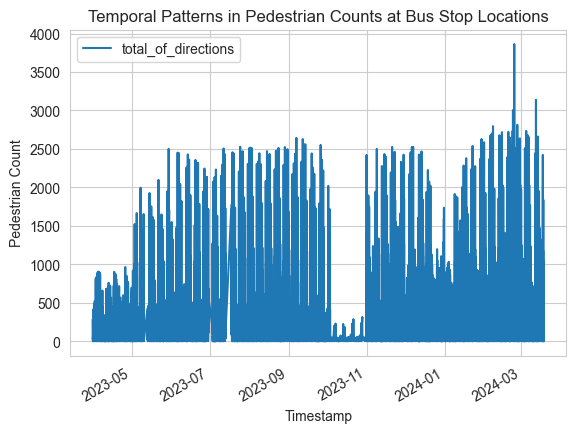

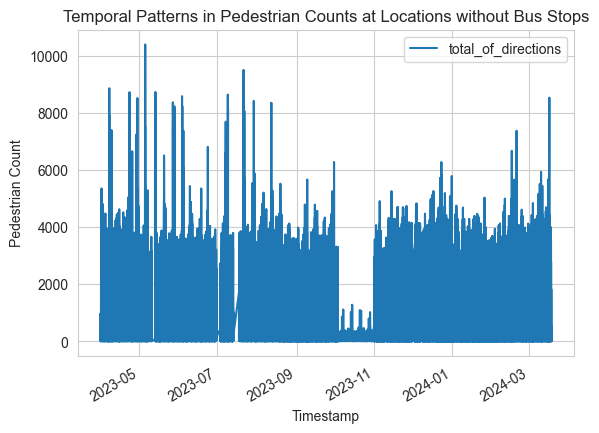

In [ ]:
# Plot temporal patterns in pedestrian counts at locations with bus stops
with_stops.plot.line(x='timestamp', y='total_of_directions')
plt.title('Temporal Patterns in Pedestrian Counts at Bus Stop Locations')
plt.xlabel('Timestamp')
plt.ylabel('Pedestrian Count')

# Plot temporal patterns in pedestrian counts at locations without bus stops
no_stops.plot.line(x='timestamp', y='total_of_directions')
plt.title('Temporal Patterns in Pedestrian Counts at Locations without Bus Stops')
plt.xlabel('Timestamp')
plt.ylabel('Pedestrian Count')

plt.show()

2023 October and April are the months with the lowest count of pedestrians at bus stop locations. There is a spike in pedestrian numbers at bus stop adjacent locations in February 2024. As with the temporal investigation of the holistic data, gaps are evident in late May and early June 2023. This is assumed to be dates when no data was collected by sensors. Non-bus stop locations do not exhibit the same pattern, excepting the low pedestrian counts in October 2023 and gaps evident. There are many strong peaks in the non-bus stop adjacent pedestrian counts, the highest occurring in May.

Viewing the distribution of pedestrian counts for bus stop and non-bus stop locations may allow more trends to emerge.

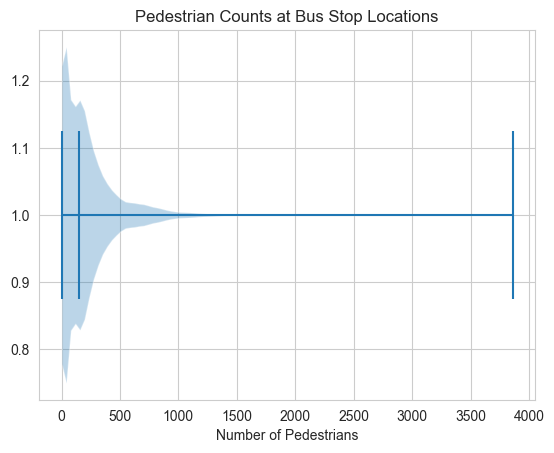

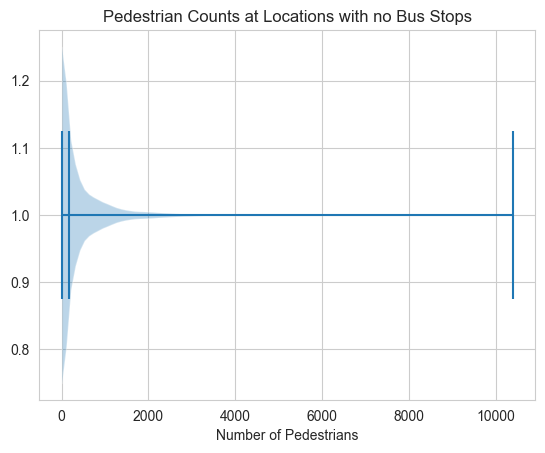

In [ ]:
# Call violin plot on bus stop pedestrian data
plt.violinplot(with_stops['total_of_directions'], showmedians=True, vert=False)
# Set plot labels and title
plt.title("Pedestrian Counts at Bus Stop Locations")
plt.xlabel('Number of Pedestrians')
plt.show()

# Call violin plot on bus stop pedestrian data
plt.violinplot(no_stops['total_of_directions'], showmedians=True, vert=False)
# Set plot labels and title
plt.title("Pedestrian Counts at Locations with no Bus Stops")
plt.xlabel('Number of Pedestrians')
plt.show()

Violin plots show distribution of pedestrian counts. The median number of pedestrians at bus stop locations is around 150 people per hour. The median value for locations that are not bus stop adjacent is around 300 people, estimated almost double that of counts at bus stop locations. Pedestrian counts at non-bus stop locations have a much larger range than those at bus stop locations; with the former ranging from 0 to 10,000 and the latter raging from 0 to approximately 3850.

Viewing relationships between weekday and monthly average pedestrian counts may allow clearer patterns to emerge.

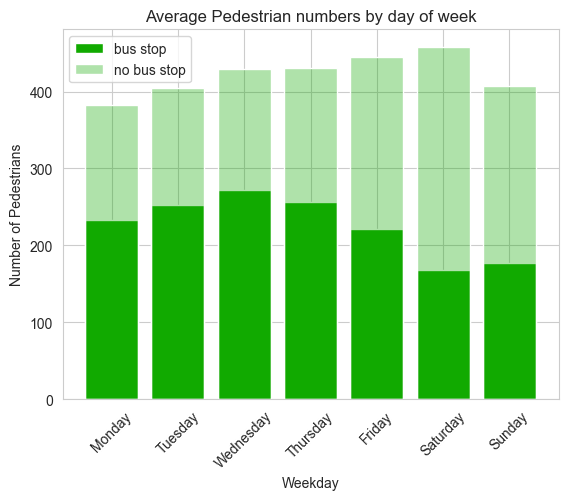

In [ ]:
# Day of week grouping and graph of average pedestrian number
# Add index column to dataframe
w_with_stops = with_stops[["timestamp","total_of_directions"]].reset_index()
w_no_stops = no_stops[["timestamp","total_of_directions"]].reset_index()
# Add weekday column to dataframe and add in weekday value from datetime column
w_with_stops['weekday'] = w_with_stops['timestamp'].dt.day_name()
w_no_stops['weekday'] = w_no_stops['timestamp'].dt.day_name()
# Group data by weekday and find average
day_with_stops = w_with_stops.groupby('weekday').mean().reset_index()
day_no_stops = w_no_stops.groupby('weekday').mean().reset_index()
# Change order of rows to weekday order
day_with_stops = day_with_stops.set_index('weekday')
day_no_stops = day_no_stops.set_index('weekday')
day_with_stops = day_with_stops.reindex(["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"]).reset_index()
day_no_stops = day_no_stops.reindex(["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"]).reset_index()

# Bar plot of pedestrian numbers each weekday
plt.bar(day_with_stops["weekday"],day_with_stops["total_of_directions"], color="#1a0", label="bus stop") 
plt.bar(day_no_stops["weekday"],day_no_stops["total_of_directions"], color="#1a05", label="no bus stop") 
plt.title('Average Pedestrian numbers by day of week')
plt.xlabel('Weekday')
plt.xticks(rotation=45)
plt.ylabel('Number of Pedestrians')
plt.legend()
plt.show()

Saturday has the highest number of pedestrians where there are no bus stops, while Wednesday has the highest number of pedestrians at areas where there are bus stops. The average number of pedestrians per day of week are around 400 for areas with no bus stops while they are around 200 for locations with bus stops. 

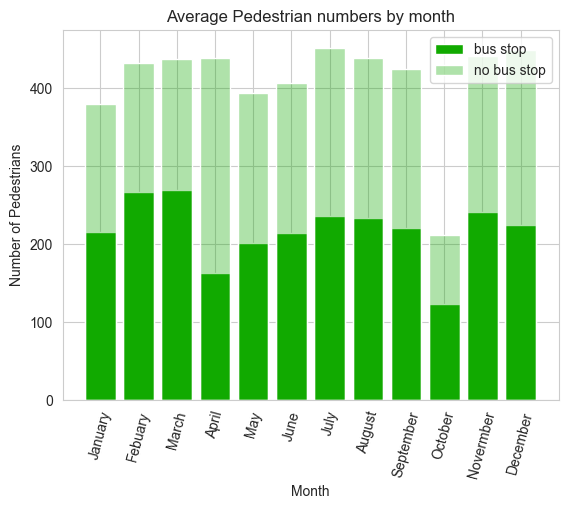

In [ ]:
# Month grouping and graph by average pedestrian number
# Add index column to dataframe
m_with_stops = with_stops[["timestamp","total_of_directions"]].reset_index()
m_no_stops = no_stops[["timestamp","total_of_directions"]].reset_index()
# Add month column to dataframe and add in weekday value from datetime column
m_with_stops['month'] = m_with_stops['timestamp'].dt.month
m_no_stops['month'] = m_no_stops['timestamp'].dt.month
# Group data by month and find average
month_with_stops = m_with_stops.groupby('month').mean().reset_index()
month_no_stops = m_no_stops.groupby('month').mean().reset_index()

# Bar plot of pedestrian numbers each month
plt.bar(month_with_stops["month"],month_with_stops["total_of_directions"], color="#1a0", label="bus stop") 
plt.bar(month_no_stops["month"],month_no_stops["total_of_directions"], color="#1a05", label="no bus stop") 
plt.title('Average Pedestrian numbers by month')
plt.xlabel('Month')
x_labels = ['January','Febuary','March','April','May','June','July','August','September','October','Novermber','December']
plt.xticks(ticks=month_with_stops["month"], labels=x_labels, rotation=75)
plt.ylabel('Number of Pedestrians')
plt.legend()
plt.show()

With a monthly view, the average number of pedestrians remains similar to weekdays; around 400 for areas with no bus stops and 200 for locations with bus stops. July recorded the greatest average number of pedestrians at locations without bus stops, while March had the greatest number of pedestrians at bus stops. October had the lowest averages for both bus stop and non bus stop locations.

It will also be usedful to investigate the dates and locations of maximum pedestrian traffic. This will be analysed using both tables and mapping.

In [ ]:
# Dates of highest pedestrian numbers at bus stop locations
# Sort table by highest number of pedestrians and print top 10
top_with_stops = with_stops.sort_values(by='total_of_directions', ascending=False).head(10)
top_with_stops

,Latitude,Longitude,geometry,timestamp,direction_1,direction_2,total_of_directions,bus_stop
287,-37.817484,144.953264,POINT (-37.817 144.953),2024-02-24 12:00:00+00:00,145,3713,3858,1
287,-37.817484,144.953264,POINT (-37.817 144.953),2024-03-12 12:00:00+00:00,89,3045,3134,1
287,-37.817484,144.953264,POINT (-37.817 144.953),2024-02-23 12:00:00+00:00,144,2861,3005,1
14,-37.812843,144.957057,POINT (-37.813 144.957),2024-02-26 21:00:00+00:00,234,2579,2813,1
14,-37.812843,144.957057,POINT (-37.813 144.957),2024-02-07 21:00:00+00:00,229,2567,2796,1
287,-37.817484,144.953264,POINT (-37.817 144.953),2024-02-23 06:00:00+00:00,1895,840,2735,1
14,-37.812843,144.957057,POINT (-37.813 144.957),2024-03-04 21:00:00+00:00,229,2505,2734,1
14,-37.812843,144.957057,POINT (-37.813 144.957),2024-02-19 21:00:00+00:00,215,2507,2722,1
14,-37.812843,144.957057,POINT (-37.813 144.957),2024-02-14 21:00:00+00:00,211,2507,2718,1
287,-37.817484,144.953264,POINT (-37.817 144.953),2024-02-24 06:00:00+00:00,1867,847,2714,1


In [ ]:
# Dates of highest pedestrian numbers at non-bus stop locations
# sort table by highest number of pedestrians and print top 10
top_no_stops = no_stops.sort_values(by='total_of_directions', ascending=False).head(10)
top_no_stops

,Latitude,Longitude,geometry,timestamp,direction_1,direction_2,total_of_directions,bus_stop
221137,-37.817673,144.950256,POINT (-37.818 144.950),2023-05-05 12:00:00+00:00,8900,1487,10387,0
356907,-37.817673,144.950256,POINT (-37.818 144.950),2023-07-21 12:00:00+00:00,8333,1163,9496,0
217186,-37.817673,144.950256,POINT (-37.818 144.950),2023-07-21 09:00:00+00:00,1081,8089,9170,0
205149,-37.817673,144.950256,POINT (-37.818 144.950),2023-04-07 09:00:00+00:00,7536,1318,8854,0
305829,-37.817673,144.950256,POINT (-37.818 144.950),2023-05-13 12:00:00+00:00,7314,1410,8724,0
202261,-37.817673,144.950256,POINT (-37.818 144.950),2023-04-23 04:00:00+00:00,868,7848,8716,0
236309,-37.817673,144.950256,POINT (-37.818 144.950),2023-07-09 04:00:00+00:00,1327,7306,8633,0
335350,-37.817673,144.950256,POINT (-37.818 144.950),2023-06-03 08:00:00+00:00,1536,7041,8577,0
494363,-37.820178,144.965089,POINT (-37.820 144.965),2024-03-16 22:00:00+00:00,640,7886,8526,0
330820,-37.817673,144.950256,POINT (-37.818 144.950),2023-04-29 09:00:00+00:00,7539,973,8512,0


Tables of the highest counts of pedestrians are shown to both bus stop and non bus stop locations. The top ten highest total of directions at non-bus stop locations are much higher than those of bus stop adjacent locations.

In [ ]:
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.815, 144.96],zoom_start = 14)

# Add pedestrian numbers at locations without bus stops
for i in range(0,len(top_no_stops)):
   folium.Marker(
      location=[top_no_stops.iloc[i]['Latitude'], top_no_stops.iloc[i]['Longitude']],
      popup=top_no_stops.iloc[i]['total_of_directions'],
      icon=folium.Icon(color="blue"),
   ).add_to(m)
   
# Add pedestrian numbers at locations with bus stops
for i in range(0,len(top_with_stops)):
   folium.Marker(
      location=[top_with_stops.iloc[i]['Latitude'], top_with_stops.iloc[i]['Longitude']],
      popup=top_with_stops.iloc[i]['total_of_directions'],
      icon=folium.Icon(color="pink"),
   ).add_to(m)

# Title for map
m.get_root().html.add_child(folium.Element("<h3 align='center'>Locations of Highest Pedestrian Numbers at Bus Stop and Non Bus Stop Locations</h3>"))

# Show the map
m

The map shows the locations that recorded the highest pedestrian counts near bus stops (in pink) and not adjacent to bus stops (in green). The locations without bus stops that record the highest pedestrian numbers are Southbank Promenade and Even Walker Bridge intersection, and Bourke Street Footbridge. The locations with bus stops that have the highest number of pedestrians are interesction of Spencer and Bourke street, as well as adjacent to Flagstaff station.

It would be useful to have the ability to enter a date period and show the average pedestian numbers at each location.

The interactive street map above shows markers in green and pink. Green represents places of pedestrian counts where there are not bus stops. Pink represents the places where there are bus stops. By clicking on the information icon, the average number of pedestrians in the time period specified can be viewed.

### ANALYSIS OF PREDICTIVE VALUE

To detemine if there are relationships between numbers of pedestrians and bus stop locations, further analysis will need to take place. From the map above, there are many more locations without bus stops than with bus stops. This assumption needs to be verified as it impacts sampling for predictive models.

In [ ]:
# Selection of columns for a dataframe that will be used for predicitive analysis
relations = ped_busstops[['bus_stop','direction_1','direction_2','total_of_directions']]

In [ ]:
# Convert bus stop data to a string
relations["bus_stop"] = relations["bus_stop"].astype('string')

# Plot treemap of bus stop and non bus stop counts
fig = px.treemap(relations, path=['bus_stop'], width=800, height=400, title="Total Locations division of Non Bus-stop Locations and Bus-stop Locations")
fig.show()


In [ ]:
# Count number of each value in bus_stop column
relations['bus_stop'].value_counts()

bus_stop
0    549915
1     48204
Name: count, dtype: Int64

The tree map and count output shows that there are many more locations in the dataset without bus stops (0) than with bus stops (1). This means that if prediction modelling takes place on the current dataset, the no bus stops will be over represented and the model will be bias. To correct for this imbalance, resampling will need to take place prior to prediction modelling or a bagging method will need to be used.

In [ ]:
# Apply z-score standardisation to all columns except bus stop
relations.update(relations.drop(columns=["bus_stop"]).apply(zscore))
relations.head(3)

,bus_stop,direction_1,direction_2,total_of_directions
5,1,-0.645071,-0.644725,-0.678027
5,1,-0.638719,-0.644725,-0.674682
5,1,-0.629192,-0.644725,-0.669664


METHOD ONE: Undersampling non-bus stop data

In [ ]:
# Undersampling no bus stop data
# Shuffle the relations dataset
shuffled_df = relations.sample(frac=1,random_state=42)

# Put all of the observations with bus stops in one dataframe.
stop_df = shuffled_df.loc[shuffled_df['bus_stop'] == 1]

# Randomly select 48204 observations from the no bus stops data and place in a dataframe
no_stop_df = shuffled_df.loc[shuffled_df['bus_stop'] != 1].sample(n=48204,random_state=42)

# Concatenate both dataframes again
undersampled_relations = pd.concat([stop_df, no_stop_df])
# Check the new sampled dataframe has the correct number of rows
undersampled_relations.shape

(48204, 4)

In [ ]:
# Set test train dataset with undersampled data
# Set the x and y variables. x = all variables except bus stop, y = bus stop
X = undersampled_relations.drop(["bus_stop"], axis=1)
y = undersampled_relations["bus_stop"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify = undersampled_relations['bus_stop'])


In [ ]:
# Find best parameters with dataset
# Set grid parameters to test
param_grid = { 
    'penalty':['l1','l2'], 
    'C':[1, 10, 100, 1000], 
} 

# Initiate grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid) 
# Fit grid search to dataset
grid_search.fit(X_train, y_train) 
# Print results of grid search
print(grid_search.best_estimator_) 

LogisticRegression(C=1)


Accuracy: 91.90%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     13291
           1       0.00      0.00      0.00      1171

    accuracy                           0.92     14462
   macro avg       0.46      0.50      0.48     14462
weighted avg       0.84      0.92      0.88     14462



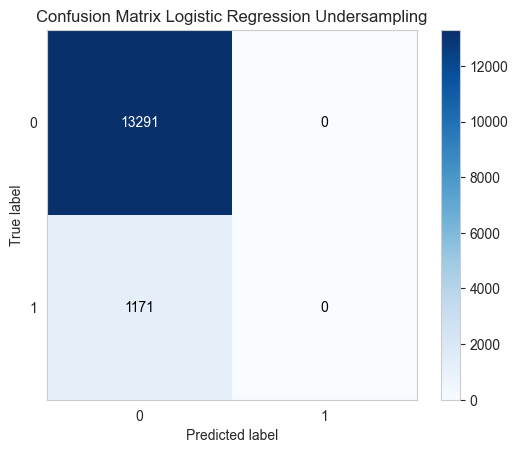

In [ ]:
# Logistic Regression with undersampling
# Initiate Logistic Regression
lr_model = LogisticRegression()

# Train model on training data
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Graph predictions against test data values
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, title = 'Confusion Matrix Logistic Regression Undersampling')

# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Show confusion matrix and classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
plt.show()


Undersampling creates a dataframe with an equal number of rows with and without a bus stop, by redusing the number of the majority rows <a href="#fn-2">[2]</a>. This is done by first taking all of the rows with bus stops out of the dataset. Then the remaining non bus stop rows are shuffled and a sample of the same number as bus stop rows is selected. This sample is then added to the bus stop data making a new dataframe.</br>

 Logistic regression prediction is used to determine the relationship between pedestrian numbers and bus stops as the bus stop variable is binary. The accuracy score function compares the predicted value to the target values. 91.9%% of the time the logistic regression model with undersampled data can accurately state if there is not a bus stop based on the number of pedestrians. On face value, this means the model is working well. However, viewing the confusion matrix allows understanding of what is really going on. The confusion matrix tells us that this models is making many false postive predictions; i.e stating that there is a bus stop when there is no bus stop. From the confusion matrix, all locations are labelled as non-bus stop locations. This shows that despite the accuracy score, the model is not working well as it cannot locate the locations with bus stops from the pedestrian data.

The first logistic regression model using undersampling suggests that pedestrian numbers cannot be used as a predictor for bus stop locations, i.e that there is not a strong relationship between these variables. However, as poor modelling may caused by having a small data set, a second approach of oversampling the bus stop data will be also investigated.

METHOD TWO: Oversampling bus stop data

In [ ]:
# Initiate SMOTE to resample data
sm = SMOTE(random_state=42)

# Set the x and y variables from the whole dataset
X = relations.drop(["bus_stop"], axis=1)
y = relations["bus_stop"]

# Use SMOTE resampling to increase but stop data with synthetic data
X, y = sm.fit_resample(X, y)

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
# Fnd best hyperparameters for dataset
# Set grid parameters to test
param_grid = { 
    'penalty':['l1','l2'], 
    'C':[1, 10, 100, 1000], 
} 

# Initiate grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid) 
# Fit grid search to dataset
grid_search.fit(X_train, y_train) 
# Print results of grid search
print(grid_search.best_estimator_) 

LogisticRegression(C=1)


Accuracy: 57.08%

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.37      0.47    165151
           1       0.55      0.77      0.64    164798

    accuracy                           0.57    329949
   macro avg       0.58      0.57      0.55    329949
weighted avg       0.58      0.57      0.55    329949



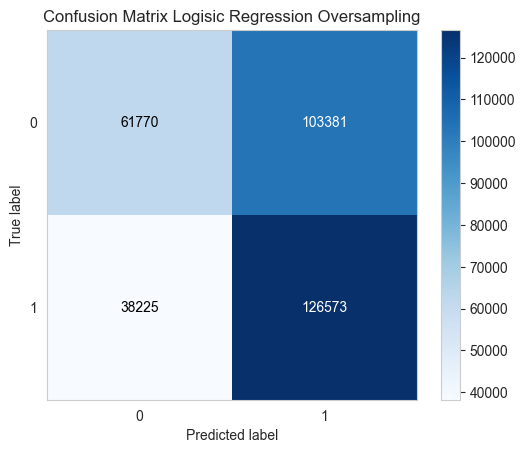

In [ ]:
# Modelling with oversampled data
# Initiate Logistic Regression
lr_model = LogisticRegression()

# Train model on training data
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Show classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Graph predictions against test data values in confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, title = 'Confusion Matrix Logisic Regression Oversampling')
plt.show()

Oversampling also creates a dataframe with an equal number of rows with and without a bus stop. This is done using the SMOTE. With the defaut parameter settings, SMOTE creates a transformed version of the dataset that balanaces the minority bus stops class <a href="#fn-3">[3]</a>. This is seen in the support column of the classification table, with almost equal values of bus stop and non-bus stop data.</br>

In logistic regression with oversampled data, the accuracy score reported is low, only 57%. Compared to the first model, on the basis of accuracy, this model is not working well. Viewing the confusion matrix collaborates this indication. In the oversampled dataset though the model was able to identify locations where there were bus stops, it also inaccurately predicted that bus stops are at locations where there are no bus stops. As there are a large number of these Type 2 errors, this mechanism of bud stop locatioin modelling is also deemed inadequate.

METHOD THREE: Bootstrapping

As both undersampling and over sampling are giving poor results, a predictive model that incorporates bootstrapping may be more suited to determining if there is a relationship between pedestrian numbers and the presence of a bus stop. As Random Forest Model has a bootstraping method built in it as been chosen for this use case. First parameter tuning will take place and then the model will be trained on the data.

In [ ]:
# Set test and train data to whole dataset
# Set the x and y variables from the whole dataset
X = relations.drop(["bus_stop"], axis=1)
y = relations["bus_stop"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
# Carry out grid test to find best parameters with data and balanced subsampling
# Set grid parameters to test
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

# Initiate grid search
grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced_subsample'), param_grid=param_grid) 
# Fit grid search to dataset
grid_search.fit(X_train, y_train) 
# Print results of grid search
print(grid_search.best_estimator_) 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=None, max_leaf_nodes=9, n_estimators=150)


Accuracy: 48.68%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.46      0.62    164962
           1       0.11      0.76      0.19     14474

    accuracy                           0.49    179436
   macro avg       0.53      0.61      0.41    179436
weighted avg       0.89      0.49      0.59    179436



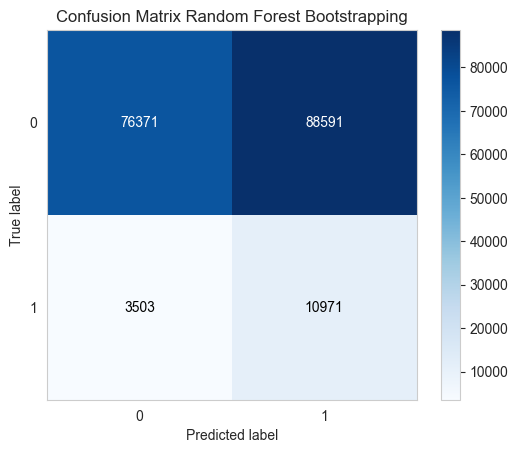

In [ ]:
# Carry out predictive modelling
# Create a Random Forest classifier with Bootstrap class weighting
rf_bcw = RandomForestClassifier(max_depth=6, max_leaf_nodes=9, n_estimators=150,random_state=42, class_weight='balanced_subsample')
 
# Train the Random Forest classifier on the training data
rf_bcw.fit(X_train, y_train)
 
# Make predictions on the test set
y_pred = rf_bcw.predict(X_test)
 
# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Show classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Graph predictions against test data values in confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, title = 'Confusion Matrix Random Forest Bootstrapping')
plt.show()

The Random Forest classifier parameter class weighting is used to address imbalance in datasets without needing to resample data outside of a predictive model. Setting this parameter to balanced subsample means that in prediction modelling more weight is given to the minority samples <a href="#fn-4">[4]</a>, i.e. where there is a bus stop.</br>

In the Random Forest classification model, the accuracy score is still low, reaching only 48%. While the precision of identifying where there were no bus stops increased, the precision of identifying a bus stop decreased significantly compared to that of Logistic regression models. The Random Forest classification also reports many more false negatives (i.e. reports that there are many fewer bus stop locations than there really are) compared to the two logistic methods investigated above. While accuracy of this model performed better than the logstic regression models, it is still evident that predictions cannot be made on the presence of a bus stop using the data availibe.

### SUMMARY OF FINDINGS

The analysis section of this use case aimed to determine if there are relationships between bus stop presence and the number of pedestrians at a location. From the data availible, it can be seen there are many more pedestrians at locations where there are no bus stops. Locations with no bus stops had higher mdeian values, higher means and higher maximum values that locations with bus stops. This pattern was seen throughout week days as well as across the months of the year. This use case also aimed to uncover temporal pattens in pedestrian numbers at bus stop and non-bus stop locations. The temporal patterns were unclear, due to a small date range in the pedestrian count datasets availible. As the pedestrian counts dataset grows in size overtime, clearer patterns may become evident.

The modelling section aimed to determine if there were strong relationships between pedestrian numbers and bus stop locations that could be used to predict bus stop locations. The main difficulty associated with this investigation was that there were few locations of overlap where bus stops and pedestrian counting occurred. Many places of pedestrain counting did not have a bus stop associated, thus making the dataset unequal in size of bus stop vs non-bus stop locations. To address this imbalance, methods of oversampling, undersampling and bootstrapping where appied to predictive modelling to determine if there was a relationship between the variables. All predictive models tested had results that do not suggest pedestrian numbers can be used to predict bus stop locations.

### FUTURE DIRECTIONS FOR RESEARCH

One of the locations of the highest number of pedestrians are seen to be at the Spencer Street Train Station entrance. It would be valuable to identify train station entry and exit points and investigate if there is a relationship between these locations across the city and the number of pedestrians. In addition, the Melbourne Cricket Ground (MCG) was also a location that was mapped as the top location for pedestrian traffic, so mapping numbers of pedestrians aginst events held at the MCG would also be a project to be considered. Another vein of investigation would be the mapping of pedestrians againt large events held in the city, including dates of concerts, sporting events and festivals.

### REFERENCES

<fn id="fn-1">[1]</fn> Melbourne City Council (2023) [Pedestrian Counting System - City of Melbourne](https://www.melbourne.vic.gov.au/about-melbourne/research-and-statistics/city-population/Pages/pedestrian-counting-system.aspx). City of Melbourne Council, Australia. 

<fn id="fn-2">[2]</fn> Jason Browne (2021) [Undersampling for Imbalanced Classification](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/). Machine Learning Mastery, Guiding Tech Media. 

<fn id="fn-3">[3]</fn> Geeks For Geeks (2024) [Handling Imbalanced Data with SMOTE and Near Miss Algorithm in Python](https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/) GeeksforGeeks.

<fn id="fn-4">[4]</fn> Geeks For Geeks (2024) [Bagging and Random Forest for Imbalanced Classification](https://www.geeksforgeeks.org/bagging-and-random-forest-for-imbalanced-classification/). GeeksforGeeks. 
